# Прогнозирование уровня средней зарабатной платы в России

In [47]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


/home/victa/anaconda2/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['product']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [48]:
data = pd.read_csv('WAG_C_M.csv',';', index_col=['month'], parse_dates=['month'], dayfirst=True)
data.rename(columns={'WAG_C_M': 'salary'}, inplace=True)
data.head()

,salary
month,
1993-01-01,15.3
1993-02-01,19.1
1993-03-01,23.6
1993-04-01,30.6
1993-05-01,37.5


### Визуальное отображение данных

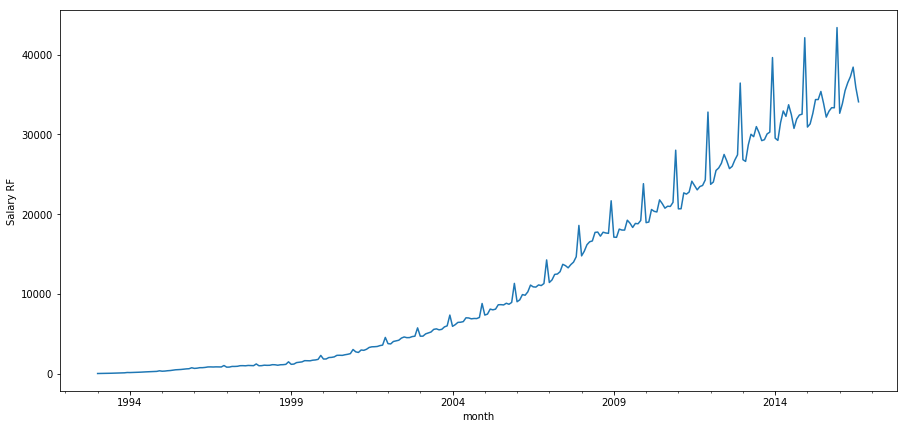

In [49]:
plt.figure(figsize(15,7))
data.salary.plot()
plt.ylabel('Salary RF')
pylab.show()

По графику видно:
1. необходимо стабилизировать дисперсию, она сильно возрастает к концу ряда
2. явно виден возрастающий тренд
3. явно видна сезонность
Ряд явно нестационарен. 
Проверим это формально с помощью критерия Дики-Фулера.

H0: ряд нестационарен H1: ряд стационарен

In [50]:
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.salary)[1])

Критерий Дики-Фуллера: p=0.991850


Критерий Дики-Фулера уверенно отвергает нулевую гипотезу о нестационарности ряда на уровне значимости 0.05.

Сделаем STL-декомпозицию.

<Figure size 1080x720 with 0 Axes>

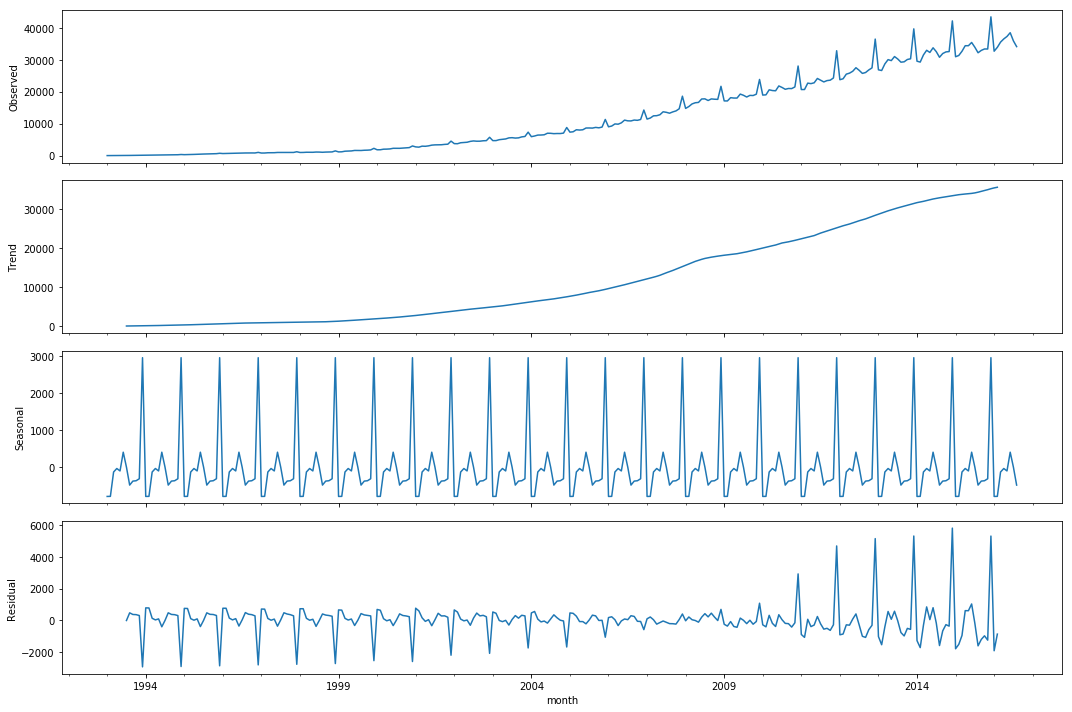

In [51]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.salary).plot();

Графики подтверждают выводы, сделанные ранее - явно возрастающий тренд, явно выраженная сезонность, еще раз убеждаемся, что ряд нельзя считать стационарным.

### Стабилизация дисперсии

Чтобы стабилизировать дисперсию, применим преобразование Бокса-Кокса.

Оптимальный параметр преобразования Бокса-Кокса: 0.263202
Критерий Дики-Фуллера: p=0.696899


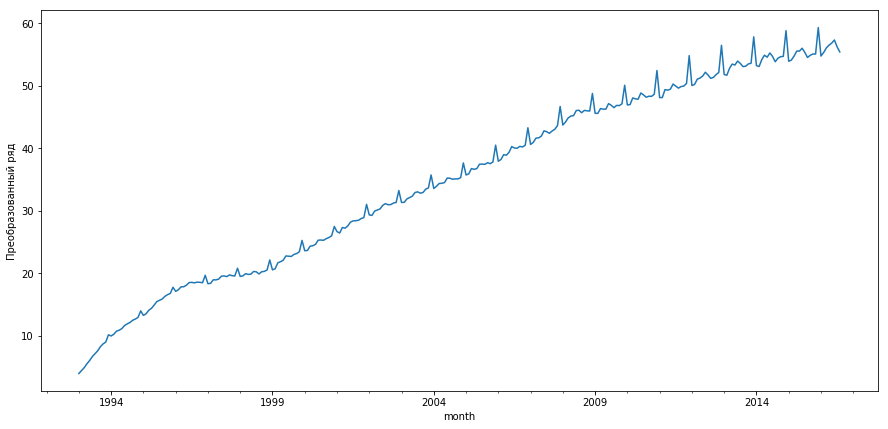

In [52]:
data['salary_box'], lmbda = stats.boxcox(data.salary)
plt.figure(figsize(15,7))
data.salary_box.plot()
plt.ylabel(u'Преобразованный ряд')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.salary_box)[1])

Дисперсия немного выровнялась, но ряд все еще нестационарен. Это показывает как критерий Дики-Фулера, так и очевидные тренд и сезонность на графике.

### Выбор порядка дифференцирования

Так как в данных явно есть сезонность, начнем с сезонного преобразования. 

Критерий Дики-Фуллера: p=0.014697


<Figure size 1080x720 with 0 Axes>

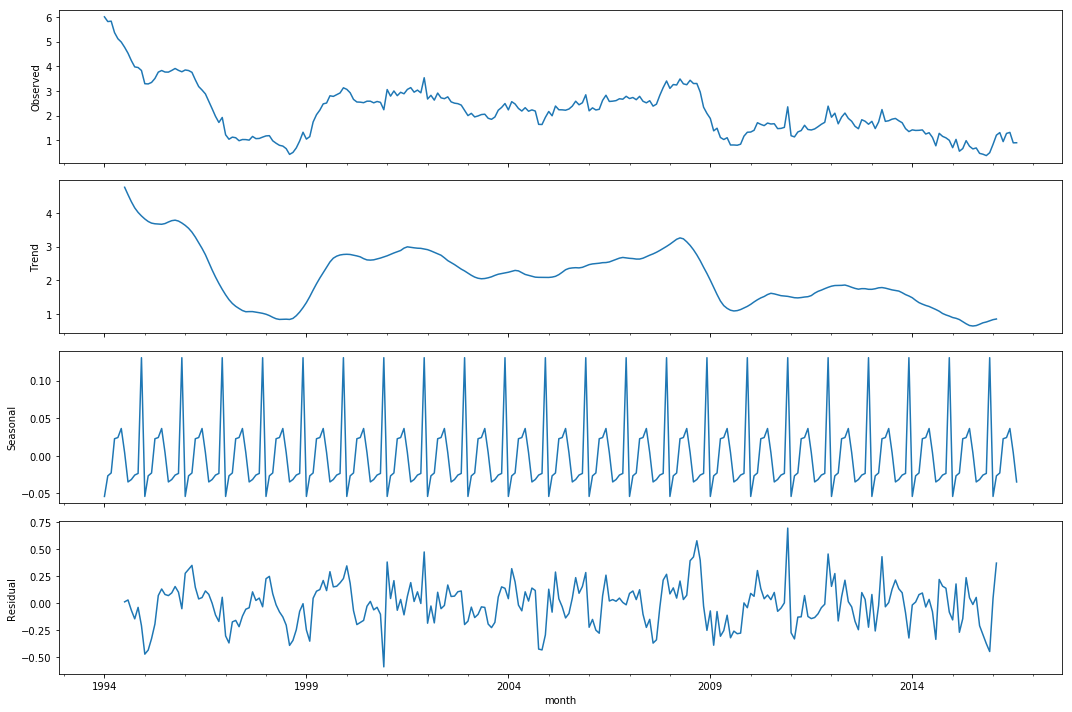

In [53]:
data['sal_box_diff_s'] = data.salary_box - data.salary_box.shift(12)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.sal_box_diff_s[12:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.sal_box_diff_s[12:])[1])

Критерий Дики-Фулера считает ряд стационарным, тренд выглядит не таким стуктурированным. В нем наблюдается явный перегиб в начале, но это вероятно, обусловлено кризисом 1998 года, и скорее является аномалией, чем отражением закономерности.
И также наблюдается небольшой спад в районе 2009 года, который, скорее всего, также отражает кризис 2008-2010 годов.
Однако тренд выглядит еще не очень ровным и в остатках кажется есть структура. Попробуем улучшить ситуацию с помощью обычного дифференцирования.

5.2036032890311276e-08

<Figure size 1080x720 with 0 Axes>

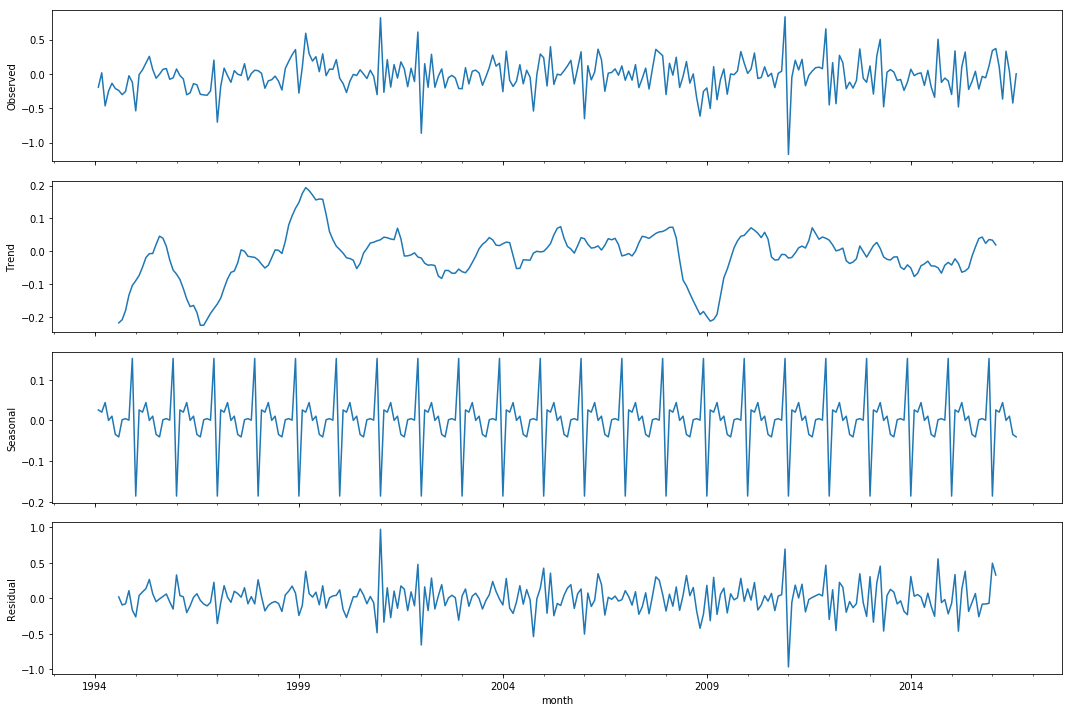

In [59]:
data['sal_box_diff'] = data.sal_box_diff_s - data.sal_box_diff_s.shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.sal_box_diff[13:]).plot()
sm.tsa.stattools.adfuller(data.sal_box_diff[13:])[1]

Теперь ряд визуально кажется более стационарным. Тренд все еще имеет перегибы в районе 1998 и 2009 годов, но в остальном примерно колеблется вокруг горизонтальной оси. Остатки больше не выглядят стуктурированными, а критерий Дики-Фулера стал совсем малым- его достигаемый уровень значимости стал порядка 
$5*10^{-8}$, значит, гипотезу о нестационарности ряда он уверенно отвергает.

## Подбор модели

Для выбора параметров модели посмотрим на графики автокорреляции и частичной автокорреляции.

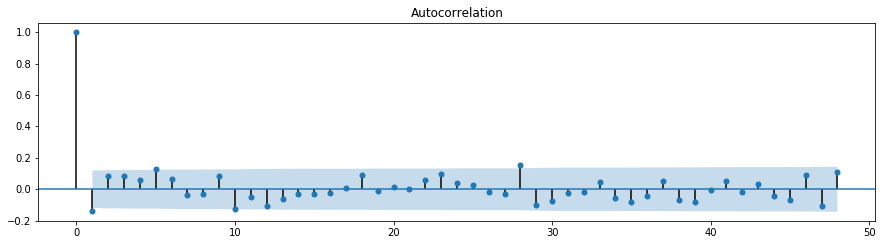

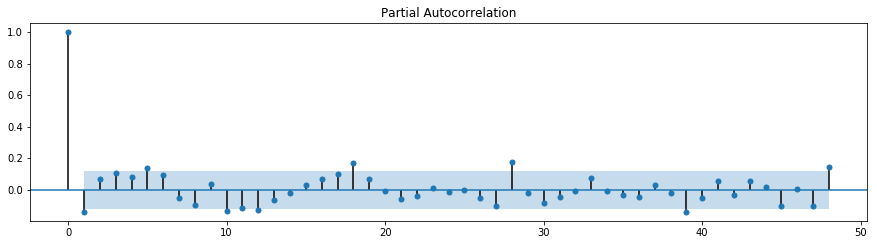

In [60]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data.sal_box_diff[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data.sal_box_diff[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()

По первому графику найдем начальные приближения Q(последний значимый сезонный лаг) и q (последний значимый лаг).
По второму - начальные приближения P(последний значимый сезонный лаг) и p(последний значимый лаг).
Начальные приближения:
    
На первом графике нет значимых сезонных лагов, поэтому Q=0

Последний значимый несезонный лаг - десятый, поэтому q=10

На втором графике последний значимый сезонный лаг имеет индекс 48, поэтому возьмем P=4

Последний значимый несезонный лаг - одинадцатый, p=11

In [82]:
ps = range(0, 11)
d=1
qs = range(0, 10)
Ps = range(0, 4)
D=1
Qs = range(0, 1)

Посмотрим на количество моделей, которые необходимо будет сравнить

In [83]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
print len(parameters_list)

440


### Сравнение моделей

In [84]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(data.salary_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

('wrong parameters:', (1, 2, 0, 0))
('wrong parameters:', (1, 2, 1, 0))
('wrong parameters:', (1, 2, 2, 0))
('wrong parameters:', (1, 2, 3, 0))
('wrong parameters:', (2, 1, 0, 0))
('wrong parameters:', (2, 1, 1, 0))
('wrong parameters:', (2, 1, 2, 0))
('wrong parameters:', (2, 1, 3, 0))
('wrong parameters:', (2, 2, 0, 0))
('wrong parameters:', (2, 2, 1, 0))
('wrong parameters:', (2, 2, 2, 0))
('wrong parameters:', (2, 2, 3, 0))
('wrong parameters:', (3, 2, 0, 0))
('wrong parameters:', (3, 2, 1, 0))
('wrong parameters:', (3, 2, 2, 0))
('wrong parameters:', (3, 2, 3, 0))
('wrong parameters:', (4, 2, 0, 0))
('wrong parameters:', (4, 2, 1, 0))
('wrong parameters:', (4, 2, 2, 0))
('wrong parameters:', (4, 2, 3, 0))
('wrong parameters:', (4, 4, 0, 0))
('wrong parameters:', (4, 4, 1, 0))
('wrong parameters:', (4, 4, 2, 0))
('wrong parameters:', (4, 4, 3, 0))
('wrong parameters:', (5, 2, 0, 0))
('wrong parameters:', (5, 2, 1, 0))
('wrong parameters:', (5, 2, 2, 0))
('wrong parameters:', (5, 2,

In [85]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
result_table.sort_values(by = 'aic', ascending=True).head()

,parameters,aic
161,"(4, 6, 1, 0)",-24.961458
185,"(5, 5, 1, 0)",-24.936089
157,"(4, 5, 1, 0)",-24.858863
186,"(5, 5, 2, 0)",-23.266149
213,"(6, 5, 1, 0)",-22.623122


In [68]:
print(best_model.summary())

                                  Statespace Model Results                                 
Dep. Variable:                          salary_box   No. Observations:                  284
Model:             SARIMAX(11, 1, 0)x(1, 1, 0, 12)   Log Likelihood                  17.831
Date:                             Wed, 25 Mar 2020   AIC                             -9.662
Time:                                     08:24:16   BIC                             37.165
Sample:                                 01-01-1993   HQIC                             9.140
                                      - 08-01-2016                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2176      0.048     -4.566      0.000      -0.311      -0.124
ar.L2          0.0205      

Модель с минимальным значением критерия Акаике получилась с параметрами Q=0 q=0 D=1 d=1 P=11 p=1.
В информации о критерии присутствует о достигаемом уровне значимости критерия Льюинга-Бокса. Он равен 0.88, это больше, чем 0.05, а значит, гипотезу о автокоррелированности остатков этой модели можно отвергнуть.

### Анализ остатков

Построим график остатков модели. 
Их атокоррелированность проверена в самой модели, о чем написано выше. 
Проверим их стационарность с помощью критерия Дики-Фуллера и несмещенность с помощью критерия Стьюдента.

Критерий Стьюдента: p=0.189628


3.131522585812434e-29

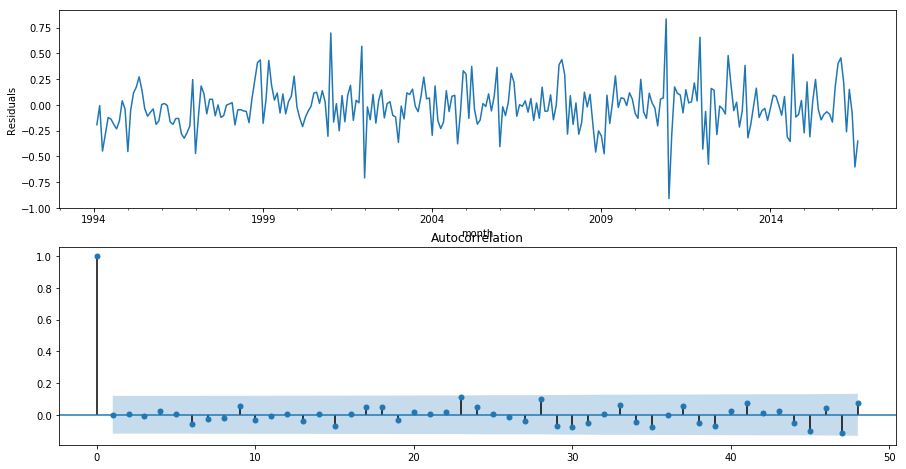

In [89]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
sm.tsa.stattools.adfuller(best_model.resid[13:])[1]

Остатки несмещены (критерий Стьюдента дает уровень значимости 0.19>0.05), стационарны (pvalue критерия Дики-Фулера
порядка $3*10^{-29}$ и неавтокоррелированы (pvalue критерия Льюиса-Бокса 0.88>0.05). 
Графики также выглядят неплохо - в графике остатков не наблюдается шума и на графике автокорреляции нет значимых точек.
Значит, модель достаточно хороша и ничего корректировать не нужно.

Посмотрим, насколько хорошо модель описывает данные

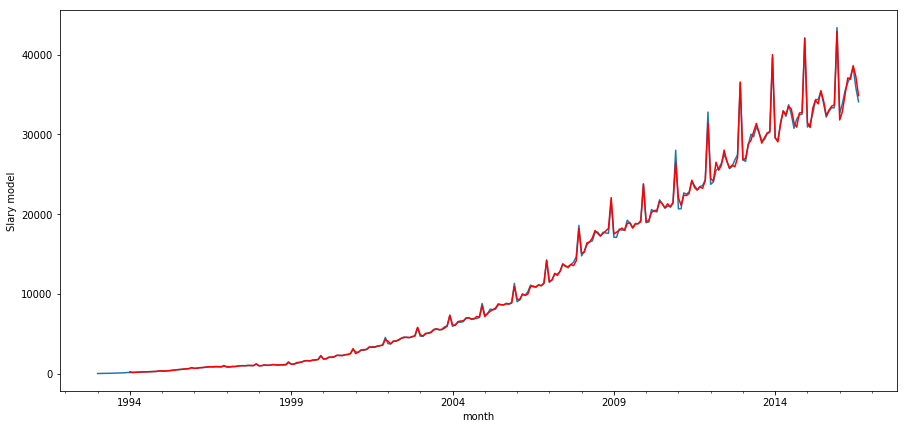

In [90]:
data['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
data.salary.plot()
data.model[12:].plot(color='r')
plt.ylabel('Slary model')
pylab.show()

Модель и данные очень похожи друг на друга.

### Прогноз

Построим прогноз до настоящего момента.

In [92]:
data2 = data[['salary']]
date_list = [datetime.datetime.strptime("2016-09-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,43)]
future = pd.DataFrame(index=date_list, columns= data2.columns)
data2 = pd.concat([data2, future])
data2['forecast'] = invboxcox(best_model.predict(start=283, end=326), lmbda)

data2[-5:]

,salary,forecast
2019-11-01,NaN,37573.784531
2019-12-01,NaN,48191.609887
2020-01-01,NaN,35734.949518
2020-02-01,NaN,36622.490640
2020-03-01,NaN,38340.382491


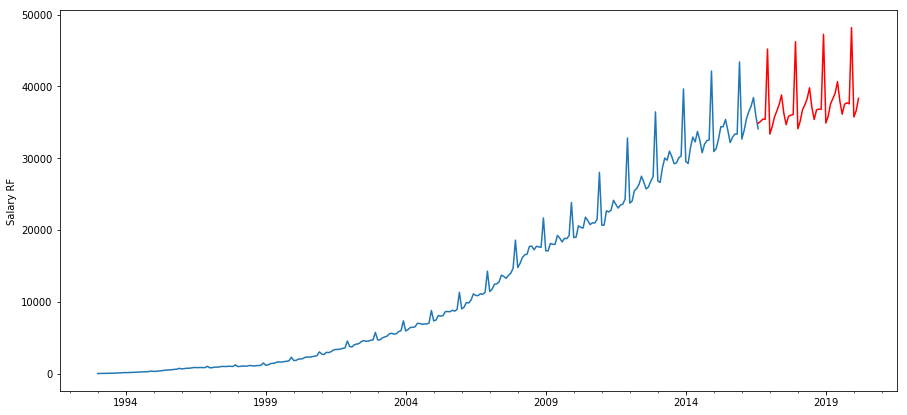

In [93]:
plt.figure(figsize(15,7))
data2.salary.plot()
data2.forecast.plot(color='r')
plt.ylabel('Salary RF')
pylab.show()